### Import Libarary

In [2]:
import cv2 
import torch
import torchvision
import torch.nn as nn
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt 

from glob import glob 

### Define Dataset

In [3]:

import xmltodict
from torch.utils.data import Dataset

"""Define Dataset 
"""
class PASCALVOCDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        """
        Args: 
            root_dir (str): Root directory to dataset 
            classes (list): class list contain strings
            transform (torch.transforms)
        
        """

        self.root_dir = root_dir
        self.img_list = glob(osp.join(root_dir, 'JPEGImages', '*.jpg'))
        self.transform = transform

        if classes:
            self.classes = classes
        else : 
            # PASCAL VOC classes
            self.classes = [
                'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                'sheep', 'sofa', 'train', 'tvmonitor'
                ]
            
        #train / val split 
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        """Return image and bbox information 
        Args: 
            idx (int): index of data
        
        Returns: 
            img (np.arr)
            bboxes (list): contains [class_idx, xmin, ymin, xmax, ymax]
        """

        img_path = self.img_list[idx]
        ann_path = img_path.replace('JPEGImages', 'Annotations')
        ann_path = ann_path.replace('.jpg', '.xml')

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        with open(ann_path) as ann_file:
            ann = ann_file.read()
            ann_dict = xmltodict.parse(ann)

        objects = ann_dict['annotation']['object']

        bboxes = []
        class_indices = []

        if isinstance(objects, list):
            pass
        else : 
            objects = [objects]

        for obj in objects :
            class_idx = self.classes.index(obj['name'])
            bbox = obj['bndbox']
            xmin, ymin = int(bbox['xmin']), int(bbox['ymin'])
            xmax, ymax = int(bbox['xmax']), int(bbox['ymax'])
            
            class_indices.append(class_idx)
            bboxes.append([xmin, ymin, xmax, ymax])
            
        sample = {'image': img, 'class':class_indices, 'bbox': bboxes}

        if self.transform: 
            sample = self.transform(sample)

        return sample


In [4]:
"""Check if Dataset works 
"""
root_dir = '/home/sss/UOS-SSaS Dropbox/05. Data/00. Benchmarks/'
dataset_dir = '02. PASCAL VOC/VOCdevkit/VOC2012'
dataset_dir = osp.join(root_dir, dataset_dir)

dataset = PASCALVOCDataset(root_dir=dataset_dir)

### Define Transforms

In [24]:
def MinMaxToWH(bbox):
    """Convert min max coordinate to width height coordinate
    Args: 
        bbox (list, [xmin, ymin, xmax, ymax])

    Returns: 
        bbox (list, [center_x, center_y, width, height])

    """
    xmin, ymin, xmax, ymax = bbox

    center_x = (xmax - xmin) / 2 + xmin
    center_y = (ymax - ymin) / 2 + ymin

    width = (xmax - xmin)
    height = (ymax - ymin)

    return [center_x, center_y, width, height]


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        """
        Args: 
            sample (dict): 
                {'image': np.arr, 'class': int, 'bbox': [xmin, ymin, xmax, ymax]}
        Returns: 
            sample (dict): same as input
        """

        image, class_indices, bboxes = sample['image'], sample['class'], sample['bbox']

        # image resize
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bboxes_out = []
        for bbox in bboxes:

            # FIXME
            xmin, ymin, xmax, ymax = bbox

            xmin = int(xmin * new_w / w)
            xmax = int(xmax * new_w / w)

            ymin = int(ymin * new_h / h)
            ymax = int(ymax * new_h / h)

            bboxes_out.append([xmin, ymin, xmax, ymax])

        return {'image': image, 'class':class_indices, 'bbox': bboxes_out}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        """
        Args: 
            sample (dict): 
                {'image': np.arr, 'class': int, 'bbox': [xmin, ymin, xmax, ymax]}
        Returns: 
            sample (dict): same as input
        """

        image, class_indices, bboxes = sample['image'], sample['class'], sample['bbox']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        bboxes_out = []
        for bbox in bboxes:

            # FIXME
            xmin, ymin, xmax, ymax = bbox

            xmin = np.clip(xmin - left, 0, new_w-1)
            xmax = np.clip(xmax - left, 0, new_w-1)

            ymin = np.clip(ymin - top, 0, new_h-1)
            ymax = np.clip(ymax - top, 0, new_h-1)

            bboxes_out.append([xmin, ymin, xmax, ymax])

        return {'image': image, 'class':class_indices, 'bbox': bboxes_out}


class ToWHCoord(object):
    """Convert bbox [xmin, ymin, xmax, ymax] to [center_x, center_y, width, height]
    """

    def __call__(self, sample): 
        
        bboxes = sample['bbox']
        bboxes_out = []

        for _bbox in bboxes: 
            bbox = MinMaxToWH(_bbox)
            bboxes_out.append(bbox)
        
        sample['bbox'] = bboxes_out

        return sample



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, class_indices, bboxes = sample['image'], sample['class'], sample['bbox']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        class_indices = torch.tensor(class_indices)
        bboxes = torch.tensor(bboxes)

        return {'image': image, 'class':class_indices, 'bbox': bboxes}


class ToYOLOLabel(object):

    def __init__(self, image_size=448, grid_size=7, num_bbox_cell=2, num_class=20):
        """
        Args: 
            image_size (int): input image size default=448 same as original paper
            grid_size (int) : grid size of YOLO prediction, default=7 same as original paper
            num_bbox_cell (int) : number of bounding box cells, defualt=2 same as original paper
            num_classes (int): default=20 for PASCAL VOC 2012 dataset
        """
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_bbox_cell = num_bbox_cell 
        self.num_class = num_class

    def __call__(self, sample):
        """
        Args: 
            sample (dict): 
                image 
                bboxes (torch.tensor, [center_x, center_y, width, height] * num_obj) 
                class_indices (torch.tensor, num_obj)

        Returns:
            sample (dict): 
                image 
                label (torch.tensor): yolo label

        """

        image, class_indices, bboxes = sample['image'], sample['class'], sample['bbox']

        image_size = self.image_size
        grid_size = self.grid_size
        num_bbox_cell = self.num_bbox_cell 
        num_class = self.num_class


        cell_size = image_size / grid_size

        label_depth = 5 * num_bbox_cell + num_class
        yolo_label = torch.zeros(grid_size, grid_size, label_depth)

        for bbox, class_idx in zip(bboxes, class_indices) : 

            c_x, c_y, w, h = bbox

            normalized_w, normalized_h = w / image_size, h / image_size    

            cell_i, cell_j = int(c_x // cell_size), int(c_y // cell_size) # assign to i, j cell
            offset_x, offset_y = (c_x % cell_size) / cell_size, (c_y % cell_size) / cell_size

            for idx in range(num_bbox_cell):
                B = idx * 5
                yolo_label[cell_j, cell_i, B] = offset_x
                yolo_label[cell_j, cell_i, B+1] = offset_y
                yolo_label[cell_j, cell_i, B+2] = normalized_w
                yolo_label[cell_j, cell_i, B+3] = normalized_h
                yolo_label[cell_j, cell_i, B+4] = 1.0

            yolo_label[cell_j, cell_i, 5*num_bbox_cell + class_idx] = 1.0

        return {'image': image, 'label': yolo_label}
        


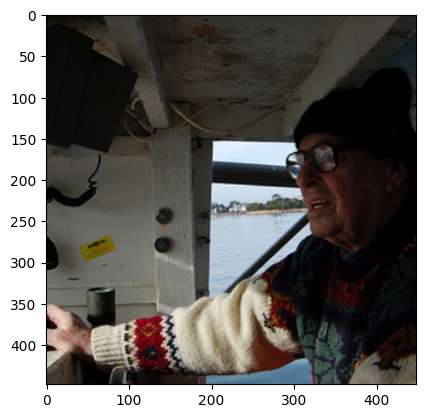

In [28]:
from random import randint 

from torchvision.transforms import Compose

transforms = Compose([
    Rescale(512),
    RandomCrop(448),
    ToWHCoord(),
    ToYOLOLabel()

])
dataset = PASCALVOCDataset(root_dir=dataset_dir, transform=transforms)

idx = randint(0, len(dataset))

data = dataset[idx]
data['label'].shape
image = data['image']

plt.imshow(image)

In [ ]:
from random import randint 

from torchvision.transforms import Compose

transforms = Compose([
    Rescale(512),
    RandomCrop(448),
    
])
dataset = PASCALVOCDataset(root_dir=dataset_dir, transform=transforms)

idx = randint(0, len(dataset))

data = dataset[idx]
bboxes = data['bbox']
img = data['image']

for bbox in bboxes:
    start_point = bbox[0], bbox[1]
    end_point = bbox[2], bbox[3]

    print(start_point)
    print(end_point)
    print(img.shape)
    img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), 2)

plt.imshow(img)

In [9]:
"""Define YOLO Model 
"""
print(f"torchvision version is {torchvision.__version__}.")

from datetime import datetime
from torchvision.models.feature_extraction import create_feature_extractor

WEIGHT = torchvision.models.ResNet50_Weights.DEFAULT

class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
    

class YOLO(nn.Module):
    def __init__(self):
        super().__init__()
        
        # use resnet 50 as backbone 
        backbone = torchvision.models.resnet50(weights=WEIGHT)
        self.backbone = create_feature_extractor(backbone, ['layer4'])
        self.avg = nn.AvgPool2d(2)
        self.conv = nn.Conv2d(2048, 1024, (1, 1))
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 1024, 4096), # the size of final layer is 7 x 7 x 2048
            nn.LeakyReLU(0.1, inplace=True),    
            nn.Linear(4096, 7 * 7 * 30), 
        )
        self.criterion = YOLOLoss()


    def forward(self, sample):
        image, label = sample['image'], sample['label']
        output = self.predict(image)
        loss = self.criterion(output, label)
        return loss 
        

    def predict(self, image):
        """
        """
        output = self.backbone(image)['layer4']
        output = self.avg(output)
        output = self.conv(output)
        output = self.fc(output.flatten())
        
        return output.view(-1, 7, 7, 30) 


model = YOLO()
tensor = torch.randn(1, 3, 448, 448)
model.forward(tensor).shape

torchvision version is 0.13.1+cu102.


torch.Size([1, 7, 7, 30])